# Backtesting asset allocation strategies

## Setup

In [1]:
from ml_strategies import random_forest
from quant_strategies import minimum_variance_portfolio
import helpers
import backtester

In [2]:
equity_symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "^GSPC"]

data = helpers.data_download(equity_symbols)
stock_return_data = data.drop('^GSPC_Close', axis=1)
index_data = data.loc[:, ['^GSPC_Close']]
sample_split_index = len(data) // 2

stock_return_data

,AAPL_Close,MSFT_Close,GOOGL_Close,AMZN_Close,TSLA_Close
Date,,,,,
2016-11-10 00:00:00-05:00,-0.027868,-0.024431,-0.031406,-0.038218,-0.024782
2016-11-11 00:00:00-05:00,0.005937,0.005451,-0.010945,-0.004539,0.017319
2016-11-14 00:00:00-05:00,-0.025085,-0.015249,-0.024010,-0.026982,-0.037707
2016-11-15 00:00:00-05:00,0.013244,0.019747,0.029128,0.033613,0.012786
2016-11-16 00:00:00-05:00,0.026888,0.013249,0.006218,0.004373,0.000871
...,...,...,...,...,...
2023-11-01 00:00:00-04:00,0.018739,0.023543,0.019101,0.029379,0.023999
2023-11-02 00:00:00-04:00,0.020693,0.006502,0.008225,0.007810,0.062482
2023-11-03 00:00:00-04:00,-0.005181,0.012862,0.012629,0.003839,0.006636


## Usage example ML strategy

In [3]:
y_training_data = stock_return_data[:sample_split_index]
X_training_data = index_data[:sample_split_index]
X_test_data = index_data[sample_split_index:]
stock_test_data = stock_return_data[sample_split_index:]

ml_strategy = random_forest.Strategy()
ml_strategy.train(y=y_training_data, X=X_training_data)
report = backtester.test_strategy(ml_strategy, X_test_data, stock_test_data)

display(f"{report.strategy_name} portfolio value: {report.portfolio_value}")
display(f"{report.strategy_name} portfolio volatility: {report.portfolio_volatility}")
display(report.portfolio_returns)
display(report.portfolio_weights)

'Random Forest portfolio value: 254.61264080085428'

'Random Forest portfolio volatility: 33.471763606453266'

Date
2020-05-13 00:00:00-04:00   -0.017035
2020-05-14 00:00:00-04:00   -0.019008
2020-05-15 00:00:00-04:00    0.010480
2020-05-18 00:00:00-04:00    0.004403
2020-05-19 00:00:00-04:00    0.012160
                               ...   
2023-11-01 00:00:00-04:00    0.004218
2023-11-02 00:00:00-04:00    0.023095
2023-11-03 00:00:00-04:00    0.019264
2023-11-06 00:00:00-05:00    0.003818
2023-11-07 00:00:00-05:00    0.009163
Name: Random Forest returns, Length: 879, dtype: float64

,AAPL_Close,MSFT_Close,GOOGL_Close,AMZN_Close,TSLA_Close
Date,,,,,
2020-05-13 00:00:00-04:00,0.152680,0.154836,0.171470,0.368335,0.152680
2020-05-14 00:00:00-04:00,0.077102,0.077102,0.077102,0.077102,0.691594
2020-05-15 00:00:00-04:00,0.161972,0.132105,0.132105,0.132105,0.441713
2020-05-18 00:00:00-04:00,0.188869,0.195157,0.188869,0.188869,0.238235
2020-05-19 00:00:00-04:00,0.176060,0.425137,0.280774,0.059014,0.059014
...,...,...,...,...,...
2023-11-01 00:00:00-04:00,0.200881,0.163069,0.163069,0.309912,0.163069
2023-11-02 00:00:00-04:00,0.189897,0.212500,0.189897,0.208488,0.199219
2023-11-03 00:00:00-04:00,0.248854,0.272042,0.166890,0.156107,0.156107


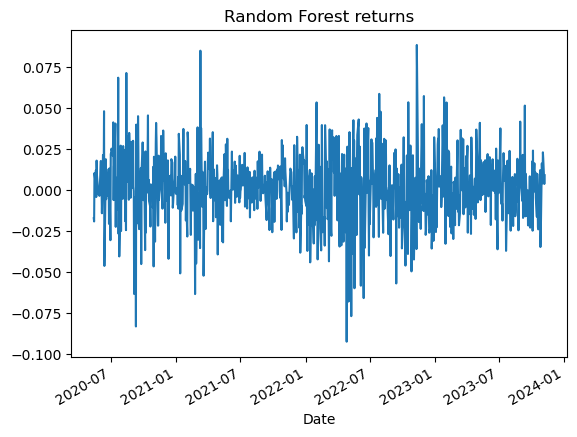

In [4]:
report.plot_portfolio_returns()

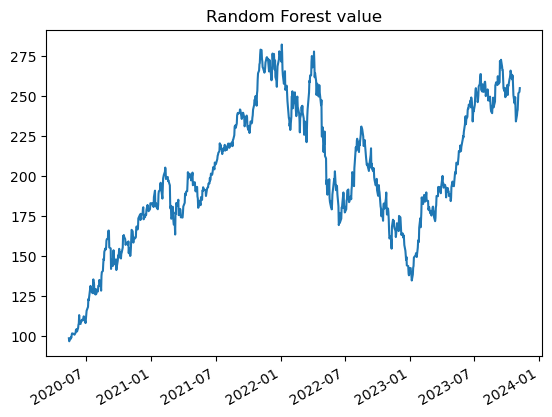

In [5]:
report.plot_portfolio_value()

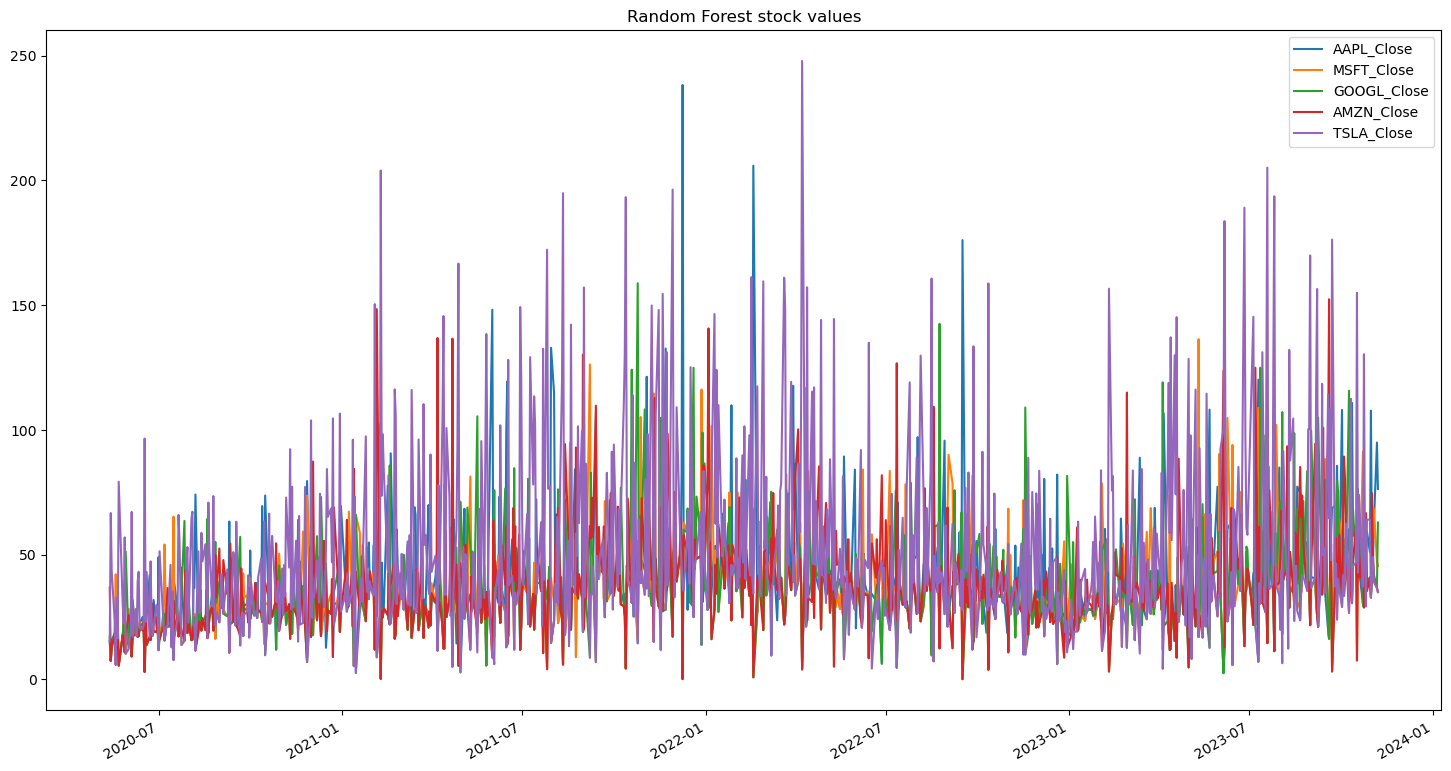

In [6]:
report.plot_asset_values()

## Usage example Quant strategy

In [7]:
training_data = stock_return_data[:sample_split_index]
test_data = stock_return_data[sample_split_index:]

quant_strategy = minimum_variance_portfolio.Strategy()
quant_strategy.train(training_data)
report = backtester.test_strategy(quant_strategy, test_data, test_data)

display(f"{report.strategy_name} portfolio value: {report.portfolio_value}")
display(f"{report.strategy_name} portfolio volatility: {report.portfolio_volatility}")
display(report.portfolio_returns)
display(report.portfolio_weights)

'Minimum Variance portfolio value: 191.96394244849415'

'Minimum Variance portfolio volatility: 28.53321453953585'

Date
2020-05-13 00:00:00-04:00   -0.018380
2020-05-14 00:00:00-04:00   -0.011541
2020-05-15 00:00:00-04:00    0.007156
2020-05-18 00:00:00-04:00    0.007316
2020-05-19 00:00:00-04:00    0.011577
                               ...   
2023-11-01 00:00:00-04:00    0.001265
2023-11-02 00:00:00-04:00    0.022483
2023-11-03 00:00:00-04:00    0.012905
2023-11-06 00:00:00-05:00    0.006823
2023-11-07 00:00:00-05:00    0.009386
Name: Minimum Variance returns, Length: 879, dtype: float64

,AAPL_Close,MSFT_Close,GOOGL_Close,AMZN_Close,TSLA_Close
Date,,,,,
2020-05-13 00:00:00-04:00,0.18373,0.125641,0.383172,0.257458,0.05
2020-05-14 00:00:00-04:00,0.18373,0.125641,0.383172,0.257458,0.05
2020-05-15 00:00:00-04:00,0.18373,0.125641,0.383172,0.257458,0.05
2020-05-18 00:00:00-04:00,0.18373,0.125641,0.383172,0.257458,0.05
2020-05-19 00:00:00-04:00,0.18373,0.125641,0.383172,0.257458,0.05
...,...,...,...,...,...
2023-11-01 00:00:00-04:00,0.18373,0.125641,0.383172,0.257458,0.05
2023-11-02 00:00:00-04:00,0.18373,0.125641,0.383172,0.257458,0.05
2023-11-03 00:00:00-04:00,0.18373,0.125641,0.383172,0.257458,0.05


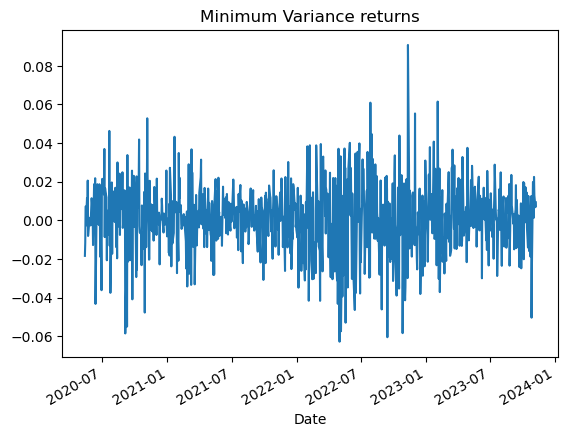

In [8]:
report.plot_portfolio_returns()

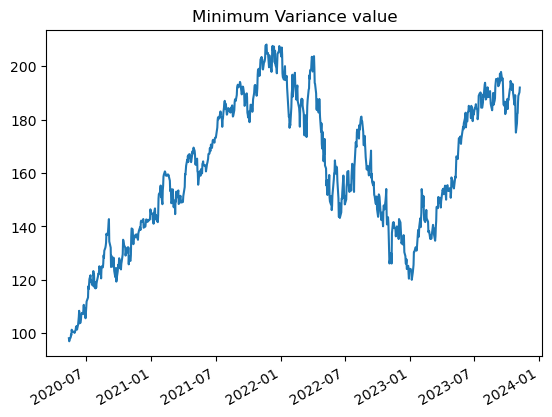

In [9]:
report.plot_portfolio_value()

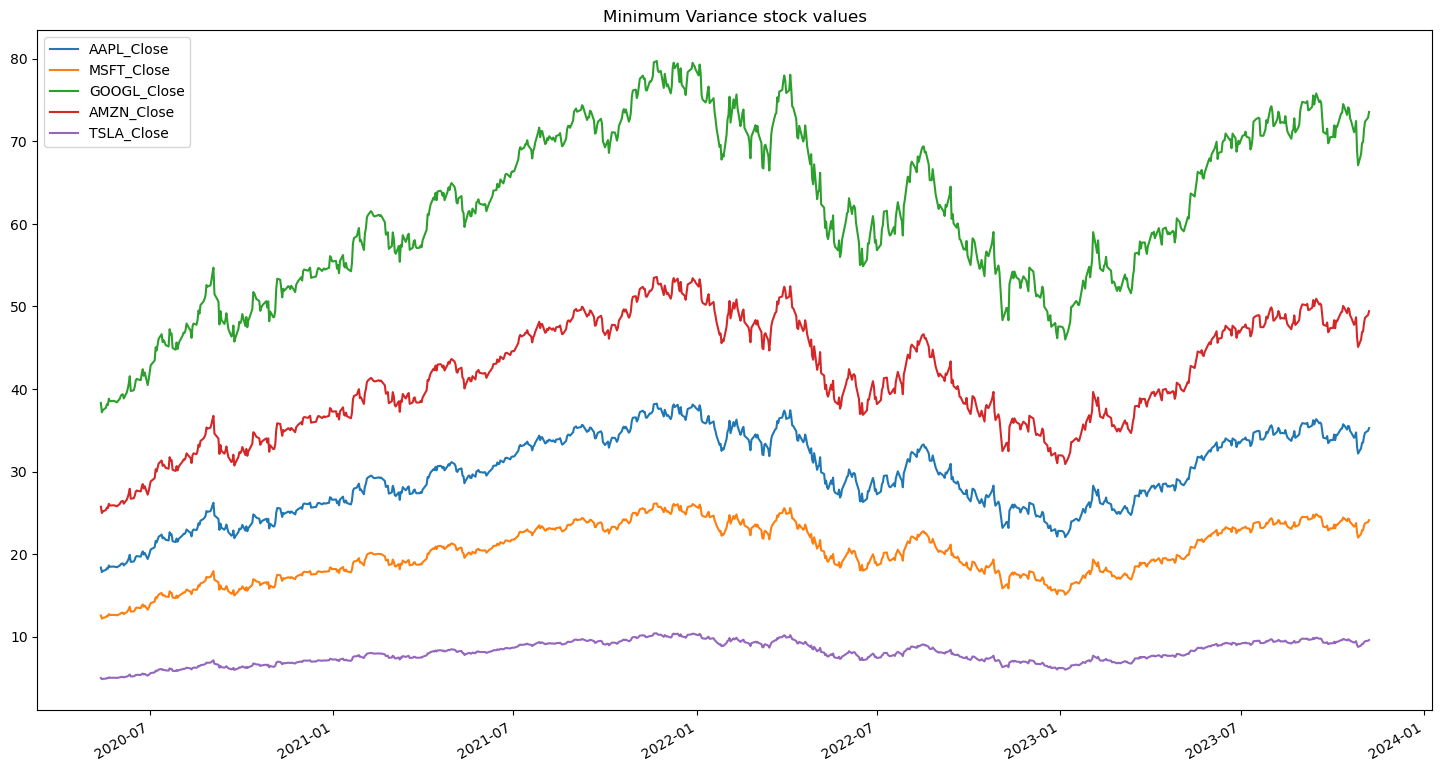

In [10]:
report.plot_asset_values()